In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!pwd

/content


In [69]:
%cd /content/drive/MyDrive/랩실/2024_DLMATHon

/content/drive/MyDrive/랩실/2024_DLMATHon


In [70]:
!unzip -qq "/content/drive/MyDrive/랩실/2024_DLMATHon/ddubuk_cls.zip"

In [60]:
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

In [61]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [62]:
!pip install pyheif

In [63]:
import os
import glob
from PIL import Image
import pyheif

In [64]:
def convet_name(dtype, buktype, extension):
  files = glob.glob("/content/drive/MyDrive/랩실/2024_DLMATHon/ddubuk/" + dtype + "/" + buktype + "/*." + extension)
  for name in files:
    new_name = os.path.splitext(name)[0] + '.jpg'

    if extension == 'HEIC':
      heif_file = pyheif.read(name)
      image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
        )
      image = image.convert('RGB')
      image.save(new_name, "JPEG")
      os.remove(name)
    else:
      img = Image.open(name).convert('RGB')
      img.save(new_name, 'jpeg')
      os.remove(name)

In [65]:
convet_name('train', 'ddubuk', 'HEIC')
convet_name('train', 'ddubuk', 'PNG')
convet_name('train', 'ddubuk', 'JPG')

In [66]:
convet_name('train', 'not_ddubuk', 'png')

In [67]:
convet_name('test', 'ddubuk', 'HEIC')
convet_name('test', 'ddubuk', 'PNG')

In [68]:
convet_name('test', 'not_ddubuk', 'png')

In [69]:
BATCH_SIZE = 16
EPOCHS = 50

In [70]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
val_transforms = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [71]:
trainset = datasets.ImageFolder(root = "/content/drive/MyDrive/랩실/2024_DLMATHon/ddubuk/train", transform=train_transforms)
testset = datasets.ImageFolder(root = "/content/drive/MyDrive/랩실/2024_DLMATHon/ddubuk/test", transform=val_transforms)

In [72]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [73]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


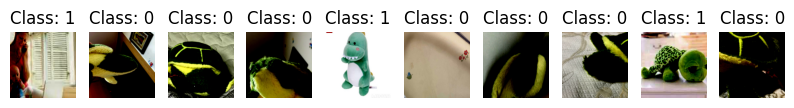

In [74]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [75]:
import torchvision.models as models
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [76]:
for parameter in model.parameters():
  parameter.requires_grad = False

In [77]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)
model = model.to(device)

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [79]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device, dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [80]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.float)
            output = model(image).squeeze(dim=1)
            output1 = output.cpu()
            output1[output1 >= 0.5] = 1
            output1[output1 < 0.5] = 0
            correct += output1.eq(label.cpu()).int().sum()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy, output

In [81]:
for epoch in range(1, EPOCHS + 1):
    train(model, trainloader, optimizer, log_interval = 5)
    valid_loss, valid_accuracy, output = evaluate(model, testloader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/98 (0%)]	Train Loss: 0.820738
Train Epoch: 1 [80/98 (71%)]	Train Loss: 0.394989

[EPOCH: 1], 	Test Loss: 0.0000, 	Test Accuracy: 71.43 % 

Train Epoch: 2 [0/98 (0%)]	Train Loss: 0.218182
Train Epoch: 2 [80/98 (71%)]	Train Loss: 0.197001

[EPOCH: 2], 	Test Loss: 0.0000, 	Test Accuracy: 71.43 % 

Train Epoch: 3 [0/98 (0%)]	Train Loss: 0.294997
Train Epoch: 3 [80/98 (71%)]	Train Loss: 0.380115

[EPOCH: 3], 	Test Loss: 0.0000, 	Test Accuracy: 71.43 % 

Train Epoch: 4 [0/98 (0%)]	Train Loss: 0.293622
Train Epoch: 4 [80/98 (71%)]	Train Loss: 0.262382

[EPOCH: 4], 	Test Loss: 0.0000, 	Test Accuracy: 71.43 % 

Train Epoch: 5 [0/98 (0%)]	Train Loss: 0.213088
Train Epoch: 5 [80/98 (71%)]	Train Loss: 0.197743

[EPOCH: 5], 	Test Loss: 0.0000, 	Test Accuracy: 71.43 % 

Train Epoch: 6 [0/98 (0%)]	Train Loss: 0.371748
Train Epoch: 6 [80/98 (71%)]	Train Loss: 0.190515

[EPOCH: 6], 	Test Loss: 0.0000, 	Test Accuracy: 76.19 % 

Train Epoch: 7 [0/98 (0%)]	Train Loss: 0.211178
Train Epoc

In [82]:
torch.save(model.state_dict(), '/content/drive/MyDrive/랩실/2024_DLMATHon/model_state_dict.pth')

In [83]:
from sklearn.metrics import roc_curve, auc

In [96]:
def calculate_roc_auc(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.float)
            output = model(image)

            all_labels.append(label.cpu().numpy())
            all_probs.append(output.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # ROC 곡선과 AUC 계산
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # ROC 곡선 출력
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f'AUC Score: {roc_auc:.4f}')

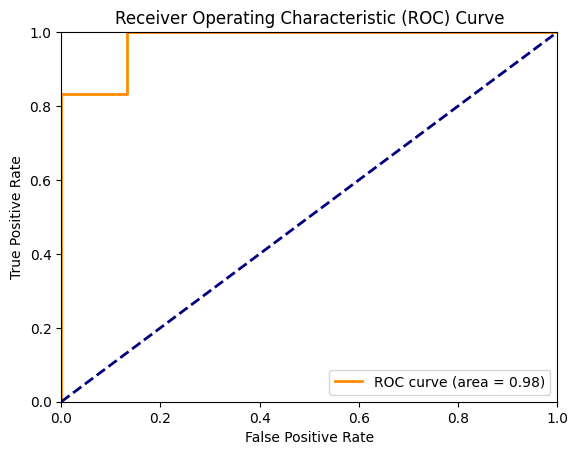

AUC Score: 0.9778


In [97]:
calculate_roc_auc(model, testloader)